# Mean Flow

In [14]:
import torch
from torch import nn, Tensor
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

In [15]:
class MeanFlow(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int):
        super(MeanFlow, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim + 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )
    
    # predict velocity field at time t for input x_t
    def forward(self, x_t: Tensor, r: Tensor, t: Tensor) -> Tensor:
        # concatenate time with input: (B, 1) and (B, D) -> (B, D+1)
        return self.net(torch.cat([r, t, x_t], dim=-1))
    

def sampler_r_t(n_samples: int) -> Tensor:
    # sample r and t such that 0 <= r < t <= 1
    # r is uniformly sampled from [0, 1]
    # t is uniformly sampled from [r, 1]
    r = torch.rand(n_samples, 1)
    t = r + torch.rand(n_samples, 1) * (1 - r)
    # 
    return r, t

In [22]:
# training 
meanflow = MeanFlow(input_dim=2, hidden_dim=64)
optimizer = torch.optim.Adam(meanflow.parameters(), lr=1e-4)
loss_fn = nn.MSELoss()

epochs = 10000
for epoch in range(epochs):
    
    # generate data
    x = Tensor(make_moons(n_samples=512, noise=0.05)[0])
    
    # sample r and t
    r, t = sampler_r_t(x.shape[0])
    
    # introduce noise
    e = torch.randn_like(x) 

    # interpolate
    z = (1 - t) * x + t * e
    v = e - x

    u, dudt = torch.func.jvp(meanflow, (z, r, t), (v, torch.zeros_like(r), torch.ones_like(t)))

    # target velocity field at time t
    u_tgt = v - (t - r) * dudt
    
    # backpropagation
    optimizer.zero_grad()
    loss = loss_fn(u, u_tgt.detach()) # stop gradient for u_tgt
    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')
    loss.backward()
    optimizer.step() 

Epoch 0, Loss: 1.741524577140808
Epoch 100, Loss: 1.3383539915084839
Epoch 200, Loss: 0.9397438764572144
Epoch 300, Loss: 0.7505947351455688
Epoch 400, Loss: 0.7239959239959717
Epoch 500, Loss: 0.7227413058280945
Epoch 600, Loss: 0.7206918001174927
Epoch 700, Loss: 0.7277698516845703
Epoch 800, Loss: 0.7071666717529297
Epoch 900, Loss: 0.6843053102493286
Epoch 1000, Loss: 0.6691187024116516
Epoch 1100, Loss: 0.7157244682312012
Epoch 1200, Loss: 0.7219206690788269
Epoch 1300, Loss: 0.696824312210083
Epoch 1400, Loss: 0.7425177693367004
Epoch 1500, Loss: 0.8254834413528442
Epoch 1600, Loss: 0.779461145401001
Epoch 1700, Loss: 0.6948366761207581
Epoch 1800, Loss: 0.7215007543563843
Epoch 1900, Loss: 0.6648907661437988
Epoch 2000, Loss: 0.7903745174407959
Epoch 2100, Loss: 0.7044671177864075
Epoch 2200, Loss: 0.7236642241477966
Epoch 2300, Loss: 0.6980905532836914
Epoch 2400, Loss: 0.7034358382225037
Epoch 2500, Loss: 0.768515944480896
Epoch 2600, Loss: 0.7473151683807373
Epoch 2700, Loss:

In [ ]:
# Sampling after training
num_points = 512
e = torch.randn(num_points, 2)  # initial points'
xg = e - meanflow(x_t = e, r = torch.zeros(num_points, 1), t = torch.ones(num_points, 1))


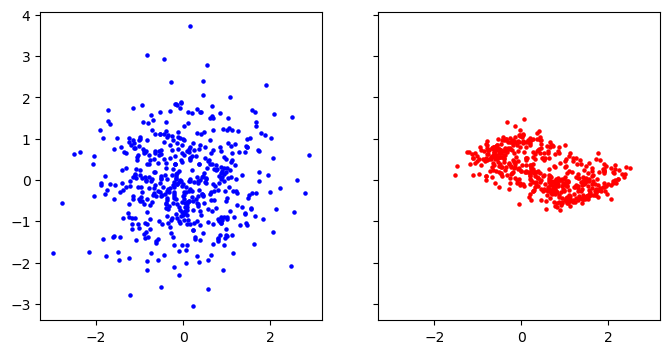

In [24]:
# plot the results
fig, axes = plt.subplots(1, 2, figsize=(8,4), sharex=True, sharey=True)
axes[0].scatter(e[:, 0].detach().numpy(), e[:, 1].detach().numpy(), s=5, c='blue', label='initial points')
axes[1].scatter(xg[:, 0].detach().numpy(), xg[:, 1].detach().numpy(), s=5, c='red', label='generated points')
